In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE

# Making a single hidden layer neural network for `SkipGram`

In [97]:
# Define the model architecture
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()  # Call the parent class constructor
        self.embeddings = nn.Embedding(vocab_size, embed_size)      # input -> hidden
        self.linear1 = nn.Linear(embed_size, vocab_size)            # hidden -> output

    def forward(self, x):
        embeds = self.embeddings(x)
        out = self.linear1(embeds)
        probs = nn.functional.log_softmax(out, dim=1)
        return probs

# Implementing the DeepWalk paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [98]:
class DeepWalk():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)

                # Initialize the model
                self.model = SkipGram(self.n, self.d)

        def unbiased_random_walk(
                self,
                adj_mat : 'list[list[int]]', 
                walk_len : 'int', 
                start_node : 'int'
        ) -> np.array:
                """
                Returns a random walk of length walk_len from start_node in the graph.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.

                Returns
                -------
                np.array
                        List of nodes in the random walk.        
                """
                # Array to store the walk
                walk = [start_node]

                # Make an adjacency matrix to easily 
                # sample the neighbors of a node.
                adj_list = []
                for i in range(len(adj_mat)):
                        # This line was autocompleted by GH Copilot
                        adj_list.append(np.where(adj_mat[i] > 0)[0])

                # Keep walking for walk_len epochs
                for epochs in range(walk_len):
                        # Randomly pick a node from the adj_list[walk[-1]] 
                        # and append it to the walk
                        walk.append(np.random.choice(adj_list[walk[-1]]))

                return np.array(walk)

        def generate_n_walks(self, num_iters : int) -> 'np.ndarray':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t
                        for _ in range(self.gamma):
                                walks.append(self.unbiased_random_walk(self.g, self.t, vertex))

                return np.array(walks)
        
        def make_word_pairs(self, walks : 'np.ndarray') -> 'np.ndarray':
                """
                Make word pairs of (context, target) from the walks.

                Parameters
                ----------
                walks : np.ndarray
                        List of walks.

                Returns
                -------
                np.ndarray
                        List of word pairs.
                """

                # List to store the word pairs
                word_pairs = []

                # For each walk
                for walk in walks:
                        # For each node in the walk
                        for node in range(len(walk)):
                                # For each node in the window
                                for window_node in range(max(0, node - self.w), min(len(walk), node + self.w)):
                                        # If the nodes are not the same
                                        if node != window_node:
                                                # Append the word pair to the list
                                                word_pairs.append((walk[node], walk[window_node]))

                return np.array(word_pairs)

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """

                # Define the loss function and optimizer
                loss_function = nn.NLLLoss()
                optimizer = optim.SGD(self.model.parameters(), lr=lr)

                # Generate many walks
                walks = self.generate_n_walks(self.epochs * 1000)

                # Make word pairs of (context, target)
                word_pairs = self.make_word_pairs(walks)

                for epoch in range(epochs):
                        total_loss = 0
                        for context, target in word_pairs:
                                context_var = Variable(torch.LongTensor([target])) # shape: [1]
                                one_hot_encoded_context = torch.zeros(self.n)
                                one_hot_encoded_context[context] = 1
                                target_var = torch.LongTensor(one_hot_encoded_context.long())    # shape: [vocab_size]

                                optimizer.zero_grad()  # Clear gradients

                                # Forward pass
                                probs = self.model(context_var).squeeze(0)  # shape: [1, vocab_size] -> [vocab_size]

                                loss = loss_function(probs, target_var)
                                total_loss += loss.item()

                                # Backward pass
                                loss.backward()

                                # Update weights
                                optimizer.step()

                        print(f"Epoch: {epoch + 1} | Loss: {total_loss}")

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return self.model.embeddings.weight.detach().numpy()
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = self.get_embeddings()

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)
                plt.show()

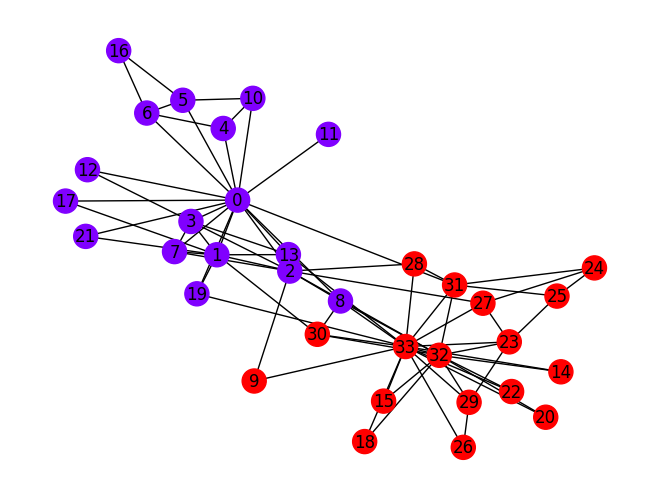

In [99]:
G = nx.karate_club_graph()
gt = []
for node in G.nodes():
    gt.append(G.nodes[node]['club'])

# Convert gt into numbers
gt_labels = np.array(gt)

# Iterate over all labels and assign them an integer
for i, label in enumerate(np.unique(gt_labels)):
        gt_labels[gt_labels == label] = i
gt_labels = gt_labels.astype(int)

nx.draw(G, with_labels=True, node_color=gt_labels, cmap=plt.cm.rainbow)
adjmat = nx.adjacency_matrix(G).todense()

In [100]:
dw = DeepWalk(adjmat, 2, 2, 5, 8)

In [101]:
dw.train(10, 0.1)

Epoch: 1 | Loss: 1221.0775839174166
Epoch: 2 | Loss: 977.7104884100845
Epoch: 3 | Loss: 939.4801537299063
Epoch: 4 | Loss: 928.213300051284
Epoch: 5 | Loss: 922.2762250453234
Epoch: 6 | Loss: 918.5205577695742
Epoch: 7 | Loss: 916.0002688171808
Epoch: 8 | Loss: 914.22846281901
Epoch: 9 | Loss: 912.9252727241255
Epoch: 10 | Loss: 911.9248859628569


/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


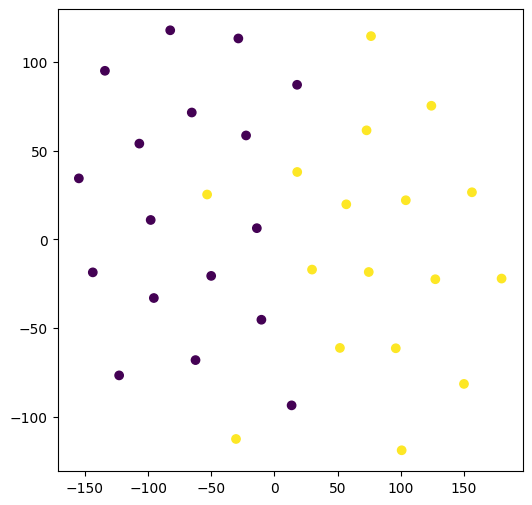

In [102]:
dw.plot_embeddings(2, gt)

## Do K-clustering with `k = 4`